# Geometrical optics

This notebook aims to implement the geometrical optics approach charactrerized by the eikonal equation and a transport equation which introduces the coupling with the amplitude. The development of this approach is as follows from the scalar Helmholtz equation substituding the field by $E=Ae^{ik_0\phi}$:

$$
\nabla^2E+k^2E=0 \rightarrow \nabla^2A + \textcolor{Tomato}{2ik_0\vec{\nabla}A\cdot\vec{\nabla}\phi} - \textcolor{MediumSeaGreen}{Ak_0^2\left( \vec{\nabla} \phi \right)^2} + \textcolor{Tomato}{iAk_0 \nabla^2\phi} + \textcolor{MediumSeaGreen}{k^2 A} = 0
$$

This substitution allows to separate real (green) and imaginary (red) parts neglecting $\frac{\nabla^2A}{k^2_0} \approx 0$. Therefore, the Eikonal equation is obtained together with the transport equation:

$$
\left( \vec{\nabla} \phi \right)^2 = n(\vec{r})^2 \rightarrow \left| \vec{\nabla} \tau \right| = \frac{n(\vec{r})}{c}
$$
$$
2\vec{\nabla}A\cdot\vec{\nabla}\phi + A \nabla^2\phi = 0 \rightarrow 2\vec{\nabla}A\cdot\vec{\nabla}\tau + A \nabla^2\tau = 0
$$

### Eikonal equation

For solving this equation, I will start with the Fast Matching Method (FMM) obtained from [PyKonal's article](https://www.researchgate.net/publication/341889419_PyKonal_A_Python_Package_for_Solving_the_Eikonal_Equation_in_Spherical_and_Cartesian_Coordinates_Using_the_Fast_Marching_Method) which consists in substituding the absolute value of the gradient by its discrete equivalent. 

$$
\left| \left( \nabla \phi \right) \right| = \sum_{a = 1}^3 \max\left( \frac{1}{h_{\xi_a}}D_{ijk}^{-\xi_a}, \frac{1}{h_{\xi_a}}D_{ijk}^{+\xi_a},0 \right)
$$

Applying this discretization, the result will be compared with the real result, using $\phi = \frac{x^2y^2}{2}$ and $n = \sqrt{x^2+y^2}$:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from numba import jit, njit, types
import time
import duckdb
import skfmm
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")  # adjust as needed

from fgrinmet.geopt.utils import * 


class Queue:
    def __init__(self):
        self.queue = []
        self.queue_set = set()

    def __add__(self, element: list | tuple):
        phase, coord, n = element
        if coord not in self.queue_set:
            if len(coord) == 2:
                heapq.heappush(self.queue, (phase, coord[0], coord[1], n))
            elif len(coord) == 3:
                heapq.heappush(self.queue, (phase, coord[0], coord[1], coord[2], n))
            self.queue_set.add(coord)
        return self

    def pop(self) -> tuple[float, np.ndarray, float] | tuple[None, np.ndarray, None]:
        if len(self.queue) == 0:
            print("Queue is empty!")
            return (None, np.array([None]), None)
        while self.queue:
            extraction = heapq.heappop(self.queue)
            phase = extraction[0]
            if len(extraction) == 4:
                coord = tuple(extraction[1:3])
                n = extraction[3]
            elif len(extraction) == 5:
                coord = tuple(extraction[1:4])
                n = extraction[4]
            else:
                print("Coordinate error.")
                return (None, np.array([None]), None)
            if coord in self.queue_set:
                self.queue_set.remove(coord)
                return phase, np.array(coord), n
        return (None, np.array([None]), None)
    def has(self, coord: tuple):
        return tuple(coord) in self.queue_set

def find_neighbours(center: np.ndarray, core: np.ndarray, shape: np.ndarray, unknown: np.ndarray | None = None):
    n = len(np.shape(center))
    if n == 1:
        mincore_raw = center + core
    elif n ==2:
        mincore_raw = center[:,None] + core[None,:]
    else:
        print("Centers are not correctly structured.")
        return np.array([[np.nan, np.nan]]), np.array([np.nan])
    
    mask = np.logical_and(np.logical_not((mincore_raw < 0).any(axis=-1)),
                                np.logical_not((mincore_raw >= np.array([shape])).any(axis=-1)))
    
    if isinstance(unknown, np.ndarray):
        mask_unknown = unknown[mincore_raw[..., 0][mask], mincore_raw[..., 1][mask]]
        mask[mask] = mask_unknown
        
    return mincore_raw, mask

def grad_sol_1ord(u: np.ndarray, F: float, dx: float) -> float | None: 
    a = np.size(u)

    for i in range(a):
        if np.isinf(u).any():
            u = np.delete(u, np.argmax(u))
            a -= 1
        else:
            if a == 1:
                return dx * F + u[0] 
            b = np.sum(u)
            c = np.sum(u**2) - dx**2 * F**2
            discrim = b**2 - a * c
            if discrim > 0:
                return (b + np.sqrt(discrim)) / (a)
            else:
                u = np.delete(u, np.argmax(u))
                a -= 1
    print("Error on the calculation.")
    return None


def find_none(*variables) -> bool:
    return any(e is None for e in variables)

 

def func_speed(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()

    dif = end - start
    print(dif)
    return result

def coor_indexing(idx: np.ndarray) -> tuple:
    return tuple(idx[..., i] for i in range(idx.shape[-1]))

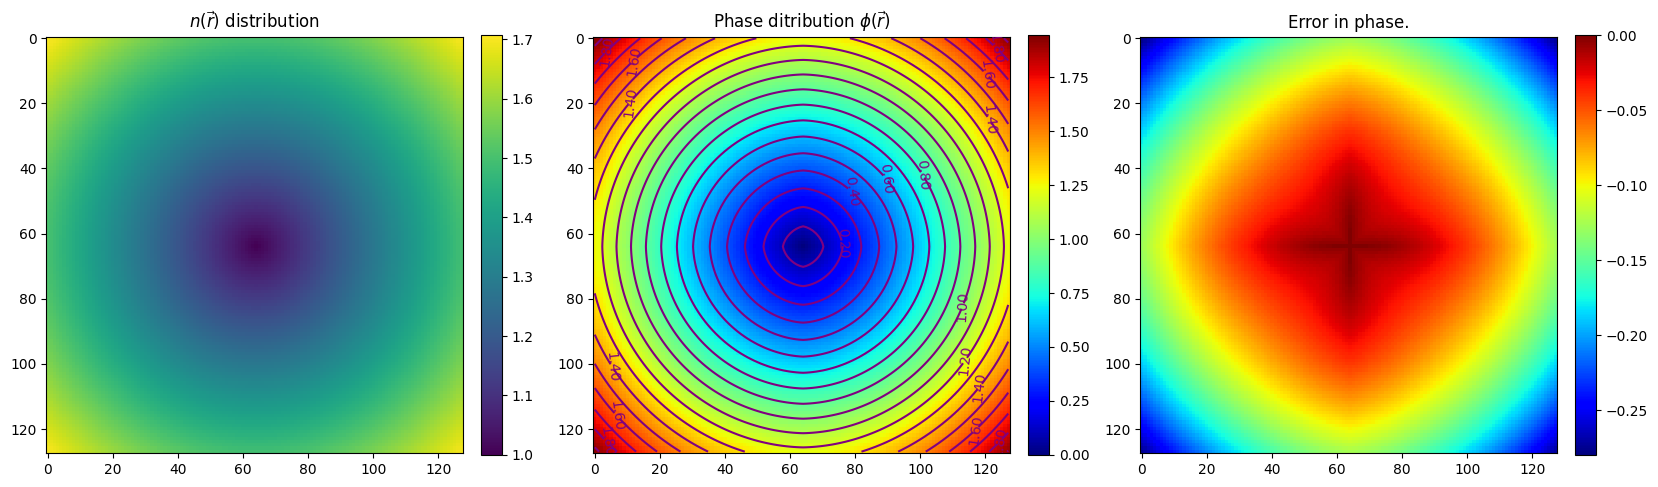

217.63665719138731


In [3]:
from matplotlib.pyplot import fignum_exists


λ = 1
c = 3e8
pix_size = 1 * λ
h = pix_size
sim_shape = np.array([128, 128])
origin = sim_shape // 2
Ly, Lx = (sim_shape[0] * pix_size, sim_shape[1] * pix_size)

steps, axes_num = define_steps(len(sim_shape))

bound = np.array([np.array([origin[0]]), np.array([origin[1]], dtype=int)]).transpose()

phase = np.full(sim_shape, np.inf)
extent_r = [-Lx/2, Lx/2, Ly/2, -Ly/2]

y = np.linspace(Ly/2, -Ly/2, sim_shape[0], endpoint=False)
x = np.linspace(-Lx/2, Lx/2, sim_shape[1], endpoint=False)
X, Y = np.meshgrid(x,y)
#Y, X = np.mgrid[Ly/2:-Ly/2:sim_shape[0]*1j, -Lx/2:Lx/2:sim_shape[1]*1j]
Y_norm, X_norm = (Y) / np.abs(Y).max(), (X) / np.abs(X).max()
#n_sup = 1 + ((Y-Y.min()) / ((Y-Y.min())).max()) + (X / X.max())**2
#n_sup = 1 + (np.sqrt((X_norm-0.5)**2 + (Y_norm-0.5)**2) <= 0.1) * 1.1
fact = 0.5
R = np.sqrt(X_norm**2 + Y_norm**2)
n_sup = 1 + R * fact 
phase_real = (R * fact)**2 / 2 + R
pix_size = Y_norm[0,0]-Y_norm[1,0]
h = pix_size

unknown = np.full(sim_shape, True)
active_queue = Queue()
for i,j in bound:
    point = [0, tuple([i, j]),  n_sup[i,j]]
    active_queue = active_queue + point

solved = np.full(sim_shape, False)

phase[bound[:,0], bound[:,1]] = 0
unknown[bound[:,0], bound[:,1]] = False

for i in range(np.prod(sim_shape)):

    # Extract the point with minimum phase on active
    min_t, min_pos, min_n = active_queue.pop()

    mincore_act_raw, mask = find_neighbours(min_pos, steps, sim_shape, unknown)
    #func_speed(find_neighbours, center = min_pos, core = steps, shape = sim_shape, unknown = unknown)

    mincore_act = mincore_act_raw[mask]

    # Find the neighbours of each neighbour
    nneighb_coord, nneighb_mask = find_neighbours(mincore_act, steps, sim_shape)

    for j in range(len(mincore_act)):

        # Extract the coordinates of the neighbour to solve and the possible second neighbours
        sol_coord = mincore_act[j]
        mask = nneighb_mask[j]
        u_arr = np.full(len(sim_shape), np.inf)
    
        for m in range(len(sim_shape)):
            
            coords = nneighb_coord[j][mask]
            axes_elem = axes_num[mask]
            nneighb_t = phase[coords[...,0], coords[...,1]]

            min_ind = np.argmin(nneighb_t)
            min_ax = axes_elem[min_ind]
            u_arr[min_ax] = nneighb_t[min_ind]
            mask *= axes_num != min_ax
        
        index_sol = tuple(sol_coord)
        n_i = n_sup[index_sol]
        F = n_sup[index_sol]
        solution = grad_sol_1ord(u_arr, F, h)

        active_queue += [solution, tuple(sol_coord), n_i]
        unknown[index_sol] = False
        solved[index_sol] = True
        phase[index_sol] = solution


import matplotlib.patheffects as path_effects

fig, sub = plt.subplots(1,3, figsize=[20,40])

ax0 = sub[0].imshow(n_sup)
plt.colorbar(ax0, ax=sub[0], fraction=0.046, pad=0.04)
sub[0].set_title("$n(\\vec{r})$ distribution")

ax1 = sub[1].imshow(phase, cmap='jet')
contours = sub[1].contour(phase, colors='purple', levels=20, linewidths=1.5)
labels = sub[1].clabel(contours, contours.levels[::2], inline=True, fontsize=10, fmt="%.2f")
plt.colorbar(ax1, ax=sub[1], fraction=0.046, pad=0.04)
sub[1].set_title("Phase ditribution $\\phi(\\vec{r})$")

ax2 = sub[2].imshow((phase_real-phase), cmap='jet')
plt.colorbar(ax2, ax=sub[2], fraction=0.046, pad=0.04)
sub[2].set_title("Error in phase.")
plt.show()

print(((phase_real-phase)**2).sum())

For the FMM scikit-fnm can be used, offering the fastest results.

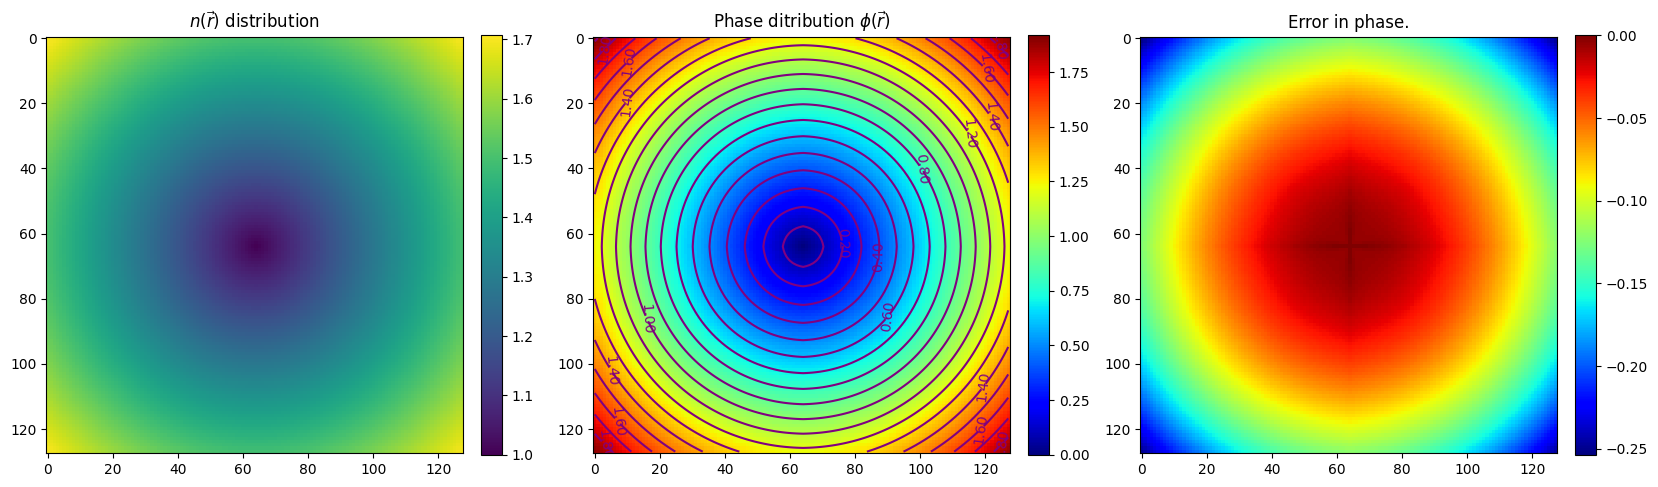

0.01029152764256111
-0.9921875


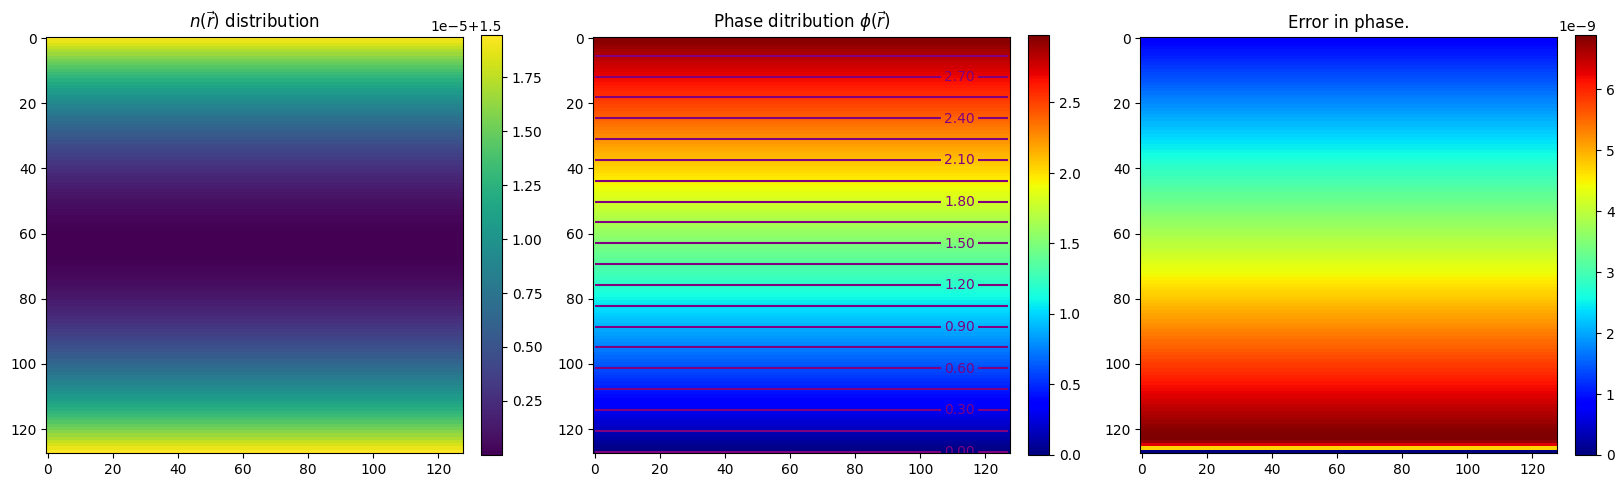

1.8566682278584168e-17


In [31]:
from numpy import dtype

# Polar distribution
y = np.linspace(Ly/2, -Ly/2, sim_shape[0], endpoint=False)
x = np.linspace(-Lx/2, Lx/2, sim_shape[1], endpoint=False)
X, Y = np.meshgrid(x,y)
Y_norm, X_norm = (Y) / np.abs(Y).max(), (X) / np.abs(X).max()

fact = 0.5
R = np.sqrt(X_norm**2 + Y_norm**2)
ic = np.full(sim_shape, np.inf, dtype=np.float64)
ic[tuple(origin)] = 0
speeds = 1 / n_sup
phase_real = (R * fact)**2 / 2 + R
phase_2d = skfmm.travel_time(ic, speeds, dx=np.array([pix_size], dtype=np.float64).repeat(len(sim_shape)))

fig, sub = plt.subplots(1,3, figsize=[20,40])

ax0 = sub[0].imshow(n_sup)
plt.colorbar(ax0, ax=sub[0], fraction=0.046, pad=0.04)
sub[0].set_title("$n(\\vec{r})$ distribution")

ax1 = sub[1].imshow(phase_2d, cmap='jet')
contours = sub[1].contour(phase_2d, colors='purple', levels=20, linewidths=1.5)
labels = sub[1].clabel(contours, contours.levels[::2], inline=True, fontsize=10, fmt="%.2f")
plt.colorbar(ax1, ax=sub[1], fraction=0.046, pad=0.04)
sub[1].set_title("Phase ditribution $\\phi(\\vec{r})$")

ax2 = sub[2].imshow((phase_real-phase_2d), cmap='jet')
plt.colorbar(ax2, ax=sub[2], fraction=0.046, pad=0.04)
sub[2].set_title("Error in phase.")
plt.show()

print(((phase_real-phase_2d)**2).sum() / np.size(phase_2d))

# Cartesian distribution

ic = np.full(sim_shape, np.inf, dtype=np.float64)
ic[-1] = 0
Y = np.zeros(sim_shape) + pix_size * (np.arange(sim_shape[0]) - (sim_shape[0]-1) / 2)[::-1,None]
w = 2 * np.pi / 1000
fac_a = 0.5
n_lin_sup = 1.5 + fac_a * np.sin(w * Y)**2
speeds = 1 / n_lin_sup
y0 = Y[-1,0]
print(y0)
C = - 1.5 * y0 - fac_a * (y0 - (np.sin(2*w*y0)/(2*w))) / 2
phase_real = 1.5 * Y + fac_a * (Y - (np.sin(2*w*Y)/(2*w))) / 2 + C
phase_2d = skfmm.travel_time(ic, speeds, dx=np.array([pix_size], dtype=np.float64).repeat(len(sim_shape)))

fig, sub = plt.subplots(1,3, figsize=[20,40])

ax0 = sub[0].imshow(n_lin_sup)
plt.colorbar(ax0, ax=sub[0], fraction=0.046, pad=0.04)
sub[0].set_title("$n(\\vec{r})$ distribution")

ax1 = sub[1].imshow(phase_2d, cmap='jet')
contours = sub[1].contour(phase_2d, colors='purple', levels=20, linewidths=1.5)
labels = sub[1].clabel(contours, contours.levels[::2], inline=True, fontsize=10, fmt="%.2f")
plt.colorbar(ax1, ax=sub[1], fraction=0.046, pad=0.04)
sub[1].set_title("Phase ditribution $\\phi(\\vec{r})$")

ax2 = sub[2].imshow((phase_real-phase_2d), cmap='jet')
plt.colorbar(ax2, ax=sub[2], fraction=0.046, pad=0.04)
sub[2].set_title("Error in phase.")
plt.show()

print(((phase_real-phase_2d)**2).sum() / np.size(phase_2d))

Now we solve the transport equation $\vec{\nabla A} \cdot \vec{\nabla \phi} + \frac{1}{2} A \nabla^2\phi=0$ by discretizing the derivatives over A to find an expresion for $A_{i,j}$, thus:

$$
A_{i,j} = \frac{A_{i-1,j} \phi^{i,j}_x + A_{i,j-1} \phi^{i,j}_y}{\phi^{i,j}_x+\phi^{i,j}_y-\frac{1}{2}\nabla^2\phi^{i,j}}
$$


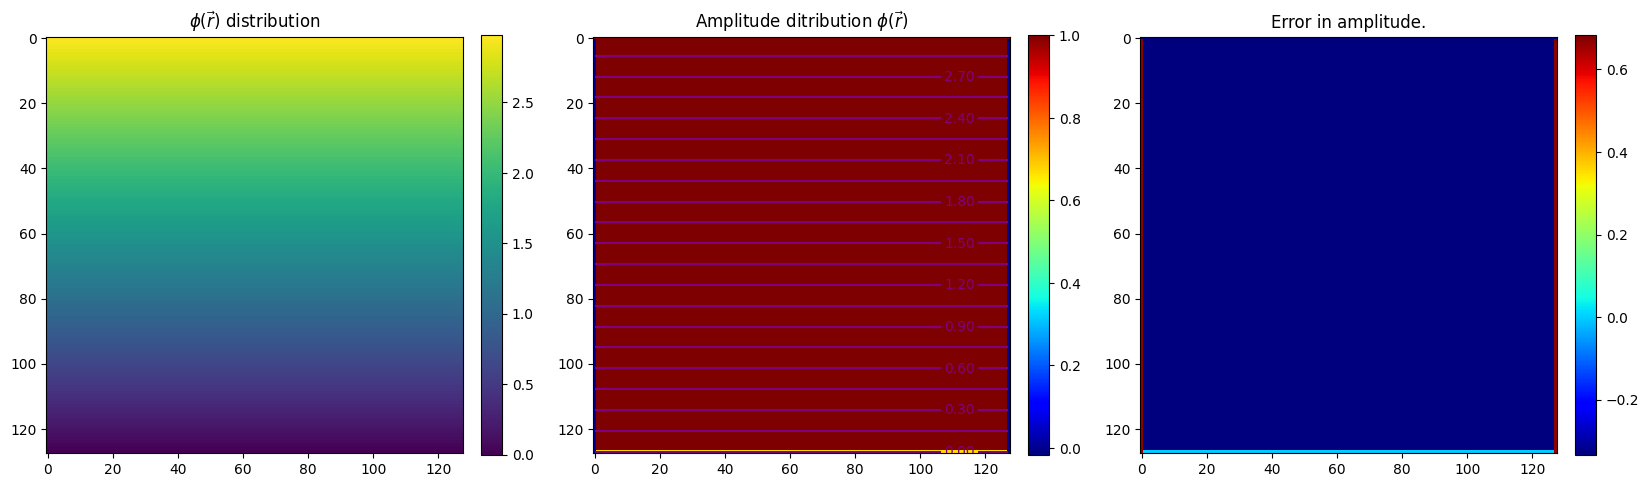

0.1154264539374974


In [ ]:
from scipy.signal import convolve2d
import torch

def FT(x):
    return torch.fft.fftshift(torch.fft.fft2(x))

def iFT(x):
    return torch.fft.ifft2(torch.fft.ifftshift(x))

def laplace_op(arr: np.ndarray, h:float = 1):
    result = np.zeros(arr.shape)
    result[1:-1, 1:-1] = (arr[:-2, 1:-1] + arr[2:, 1:-1] + arr[1:-1, :-2] + arr[1:-1, 2:] - 4*arr[1:-1, 1:-1]) / h**2
    return result

@njit()
def gauss_seidel_sol(A_0: np.ndarray, dy_phase: np.ndarray, dx_phase: np.ndarray, lap_phase: np.ndarray):
    pass

dy_phase, dx_phase = np.gradient(phase_2d, h, edge_order=2)
core = np.array([[0,1,0],[1,-4,1],[0,1,0]])

lap_phase = convolve2d(phase_2d, core, mode='same') / h**2

N = 10000
amplitude = np.zeros(sim_shape)
amplitude[0] = 1
for i in range(N): # Jacobi iterations
    amplitude[1:, 1:] = ((amplitude[1:, :-1] * dx_phase[1:, 1:] + amplitude[:-1, 1:] * dy_phase[1:, 1:]) / 
                         (dx_phase[1:, 1:] + dy_phase[1:, 1:] - 0.5 * lap_phase[1:, 1:]*h))
y0 = Y[0]
C = 1 / np.exp(0.5 * np.log(1.5 + fac_a * np.sin(w*y0)**2))
amplitude_real = C * np.exp(-0.5 * np.log(1.5 + fac_a * np.sin(w*Y)**2))

fig, sub = plt.subplots(1,3, figsize=[20,40])

ax0 = sub[0].imshow(phase_2d)
plt.colorbar(ax0, ax=sub[0], fraction=0.046, pad=0.04)
sub[0].set_title("$\\phi(\\vec{r})$ distribution")

ax1 = sub[1].imshow(amplitude, cmap='jet')
contours = sub[1].contour(phase_2d, colors='purple', levels=20, linewidths=1.5)
labels = sub[1].clabel(contours, contours.levels[::2], inline=True, fontsize=10, fmt="%.2f")
plt.colorbar(ax1, ax=sub[1], fraction=0.046, pad=0.04)
sub[1].set_title("Amplitude ditribution $\\phi(\\vec{r})$")

ax2 = sub[2].imshow((amplitude_real-amplitude), cmap='jet')
plt.colorbar(ax2, ax=sub[2], fraction=0.046, pad=0.04)
sub[2].set_title("Error in amplitude.")
plt.show()
print(((amplitude_real-amplitude)**2).sum() / np.size(phase_2d))

We compare with the case of a gaussian beam:


# Extras

In [5]:
# 3D case:

sim_shape_3d = np.array([128,128,128]) # np.array([512,512,512])
pix_size_3d = 1

x = pix_size_3d * (np.arange(sim_shape_3d[2]) - sim_shape_3d[2] / 2)
y = pix_size_3d * (np.arange(sim_shape_3d[1])[::-1] - sim_shape_3d[1] / 2)
z = pix_size_3d * (np.arange(sim_shape_3d[0]) - sim_shape_3d[0] / 2)

x_norm = x / np.abs(x).max()
y_norm = y / np.abs(y).max()
z_norm = z / np.abs(z).max()

pix_size_3d = x_norm[1]-x_norm[0]

r = x[None,None,:]**2 + y[None,:,None]**2 + z[:,None,None]**2
R = np.sqrt((x_norm**2)[None,None,:] + (y_norm**2)[None,:,None] + (z_norm**2)[:,None,None])
n_vol = 1 + R * fact 
phase_real_3d = (R * fact)**2 / 2 + R
init_phase = np.full(sim_shape_3d, np.inf, dtype=np.float64)
init_phase[tuple(sim_shape_3d // 2)] = 0
print(init_phase.shape)
print(n_vol.shape)

phase_3d = skfmm.travel_time(init_phase, 1 / n_vol, dx = np.array([pix_size_3d]).repeat(len(sim_shape_3d)))

(128, 128, 128)
(128, 128, 128)


In [6]:
import os

from numpy import dtype
from config import BASE_DIR
db_dir = os.path.join(BASE_DIR, 'data', 'db')
#os.makedirs(db_dir, exist_ok=True)
#db_path = os.path.join(db_dir, 'mydatabase.duckdb')
#con = duckdb.connect(database=db_path)

os.makedirs(db_dir, exist_ok=True)
db_dir = os.path.join(BASE_DIR, 'data', 'db')
n = 512

indices = np.memmap(os.path.join(db_dir, 'indices.dat'), dtype=np.uint32, mode="r+", shape=(n**3))
coordinates = np.memmap(os.path.join(db_dir, 'coordinates.dat'), dtype=np.float32, mode="r+", shape=(n**3))
phases = np.memmap(os.path.join(db_dir, 'phases.dat'), dtype=np.float32, mode="r+", shape=(n**3))
refrac_indxs = np.memmap(os.path.join(db_dir, 'refrac_indxs.dat'), dtype=np.float32, mode="r+", shape=(n**3))

indx = np.arange(n**3)

indx_x = np.arange(n) 
indx_y = np.arange(n)
indx_z = np.arange(n)

t = np.random.rand(n**3) + 1
X, Y, Z = np.meshgrid(x,y,z)
points = np.array([t,X.flatten(),Y.flatten(),Z.flatten(), indx]).T


print(points)

#con.close()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\david\\dev\\F-GRIN-metrology\\data\\db\\indices.dat'